# Analysis of dictionary and loading

William Colgan May 14 2023

### Setup

In [159]:
library(useful)
library(magrittr)
library(pheatmap)
library(tidyverse)
library(gprofiler2)
library(cdsrgsea)

### Load data

In [ ]:
obs = read_csv("./data/K562_gwps_obs.csv")
var = read_csv("./data/K562_gwps_var.csv")
mat = read_csv("./data/K562_gwps_norm.csv",col_names = F)
mat <- mat %>% as.matrix()
colnames(mat) <- var$gene_name
rownames(mat) <- obs$gene_transcript %>% word(2,2,sep = "_")
mat = t(mat)
mat[mat > 5]  <-  5
mat[mat < -5]  <-  -5

In [112]:
temp  <- R.matlab::readMat("./output/interim/scaled-gwps-K=80-T=4.mat")
dict <- as.matrix(temp$D)
loading  <- as.matrix(temp$X)
colnames(loading)  <- colnames(mat)
names  <- c()
for (i in 1:nrow(loading)) {
  names  %<>% append(c(paste0("P",i)))
}
rownames(loading)  <- names
colnames(dict) <- names
rownames(dict) <- rownames(mat)
id_dict  <- dict
rownames(id_dict)  <-  var$gene_id

In [59]:
gene_sets  <- read_rds("./data/gsc-data-term2gene")
corum <- gene_sets$CORUM
corum  %<>% filter(str_detect(term,"human"))  %>% mutate(term = word(term,1,1," \\("))

In [81]:
corum_unique <- corum %>%
  group_by(term) %>%
  mutate(group_size = n()) %>%
  ungroup() %>%
  arrange(desc(group_size), term) %>%
  distinct(gene, .keep_all = TRUE) %>%
  select(term, gene)

In [82]:
use_terms <- corum_unique %>% count(term)  %>% filter(n > 10)   %>% pull(term)
corum_unique  %<>% filter(term %in% use_terms)
corum_unique  %<>% rename(Complex = term)

### Loading Heatmap

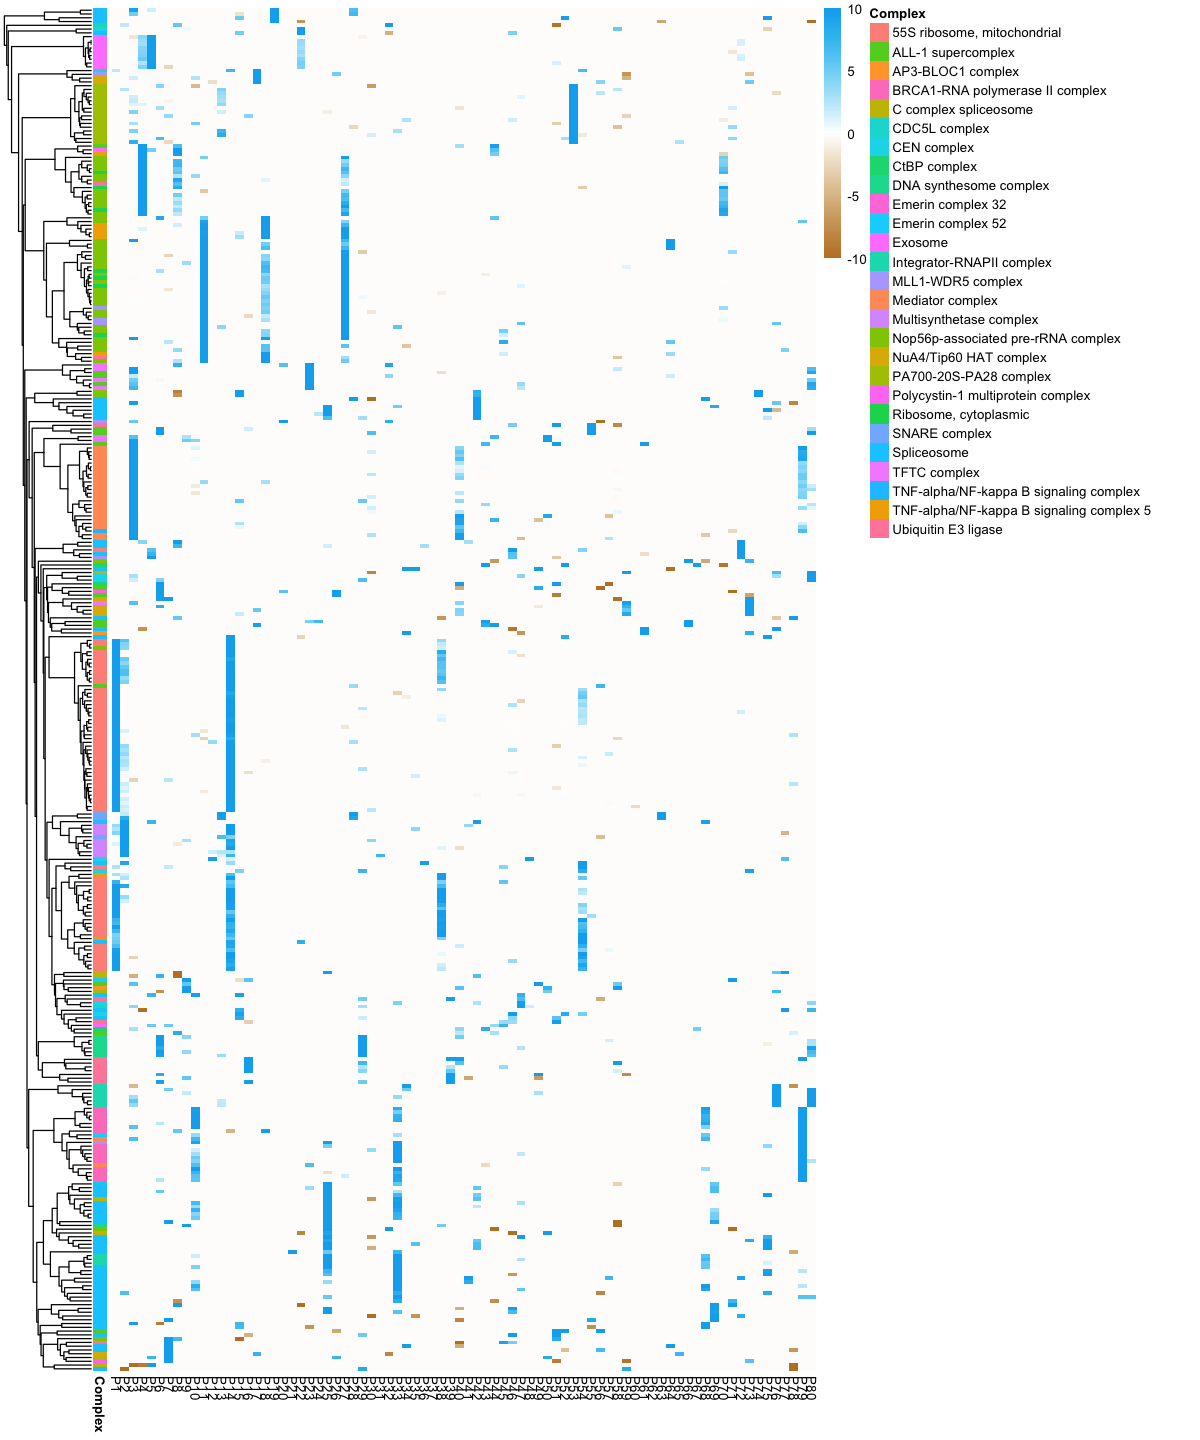

In [83]:
options(repr.plot.width=10, repr.plot.height=12)
pheatmap(t(loading[,intersect(colnames(loading),corum_unique$gene)]),cluster_cols = F,
annotation_row = corum_unique %>% column_to_rownames("gene"),
color = colorRampPalette(c("#BF812D", "white", "#00AEEF"))(100),
breaks = seq(-10, 10, length.out=101),
fontsize = 8,show_rownames = F)
pheatmap(t(loading[,intersect(colnames(loading),corum_unique$gene)]),cluster_cols = F,
annotation_row = corum_unique %>% column_to_rownames("gene"),
color = colorRampPalette(c("#BF812D", "white", "#00AEEF"))(100),
breaks = seq(-10, 10, length.out=101),
width = 10, height = 12,fontsize = 7,show_rownames = F,filename =  "./output/analysis/loading_heatmap.pdf")

Same heatmap but clustered

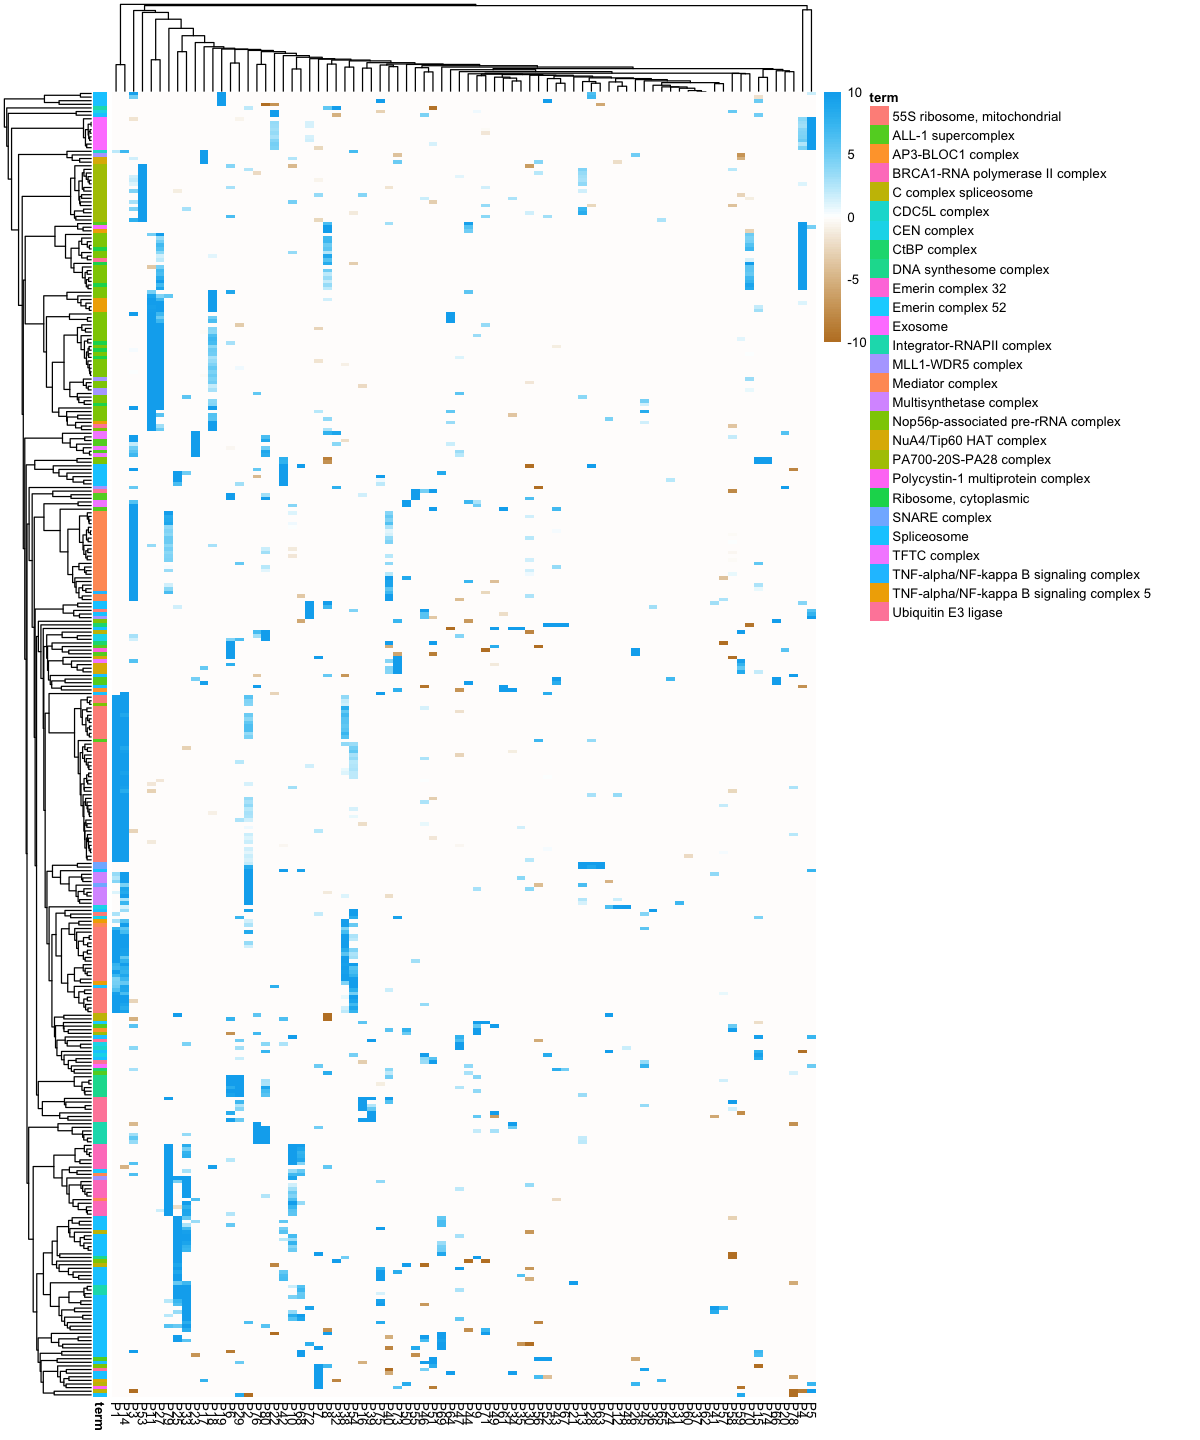

In [77]:
options(repr.plot.width=10, repr.plot.height=12)
pheatmap(t(loading[,intersect(colnames(loading),corum_unique$gene)]),cluster_cols = T,
annotation_row = corum_unique %>% column_to_rownames("gene"),
color = colorRampPalette(c("#BF812D", "white", "#00AEEF"))(100),
breaks = seq(-10, 10, length.out=101),
fontsize = 8,show_rownames = F)

### Pleitropy example

In [103]:
use_perts  <- corum  %>% filter(term %in% c("BRCA1-RNA polymerase II complex","Mediator complex"))  %>% pull(gene)
use_perts  <- use_perts  %>% setdiff(c("TBP","OPA1")) 

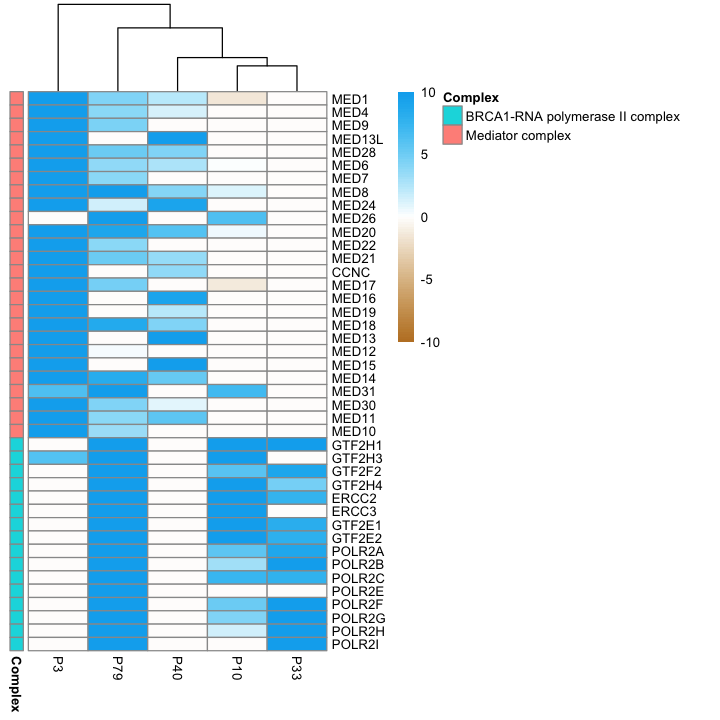

In [218]:
options(repr.plot.width=6, repr.plot.height=6)
pheatmap(t(loading[c("P3","P10","P33","P40","P79"),intersect(use_perts,colnames(loading))]),cluster_cols = T,cluster_rows = FALSE,
annotation_row = corum_unique %>% column_to_rownames("gene"),
color = colorRampPalette(c("#BF812D", "white", "#00AEEF"))(100),
breaks = seq(-10, 10, length.out=101),
fontsize = 8,show_rownames = T)
pheatmap(t(loading[c("P3","P10","P33","P40","P79"),intersect(use_perts,colnames(loading))]),cluster_cols = T,cluster_rows = FALSE,
annotation_row = corum_unique %>% column_to_rownames("gene"),
color = colorRampPalette(c("#BF812D", "white", "#00AEEF"))(100),
breaks = seq(-10, 10, length.out=101),
width = 6, height = 6,
fontsize = 8,show_rownames = T,filename =  "./output/analysis/mediator_loadings.pdf")

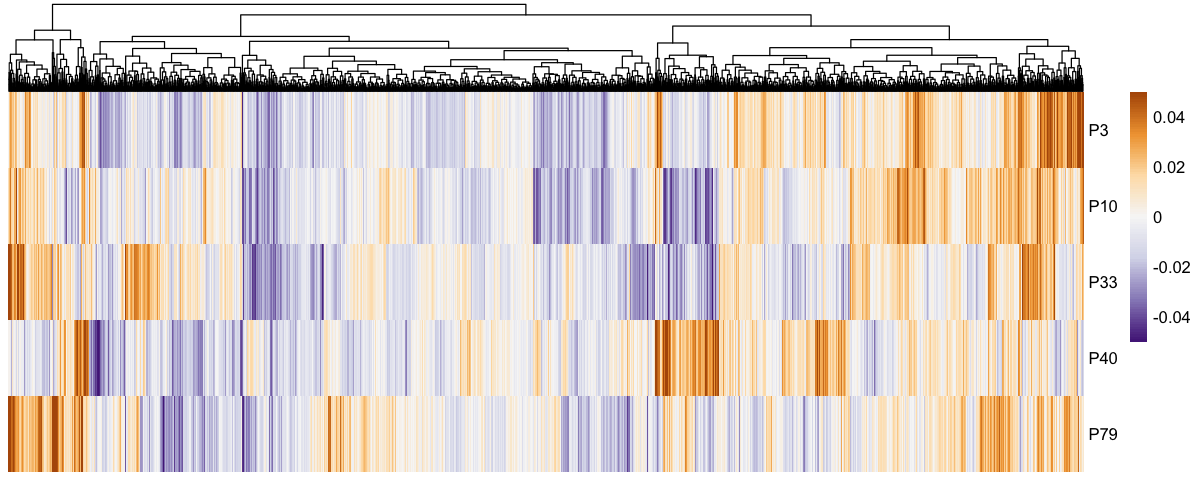

In [219]:
options(repr.plot.width=10, repr.plot.height=4)
pheatmap(t(dict[,c("P3","P10","P33","P40","P79")]),show_colnames = F,cluster_rows = F,
 color = colorRampPalette(rev(RColorBrewer::brewer.pal(n = 7, name = "PuOr")))(100),
         breaks = seq(-.05, .05, length.out=101))
pheatmap(t(dict[,c("P3","P10","P33","P40","P79")]),show_colnames = F,cluster_rows = F,
 color = colorRampPalette(rev(RColorBrewer::brewer.pal(n = 7, name = "PuOr")))(100),
         breaks = seq(-.05, .05, length.out=101),
         width = 10, height = 4,
        fontsize = 8,filename =  "./output/analysis/mediator_dictionary.pdf")

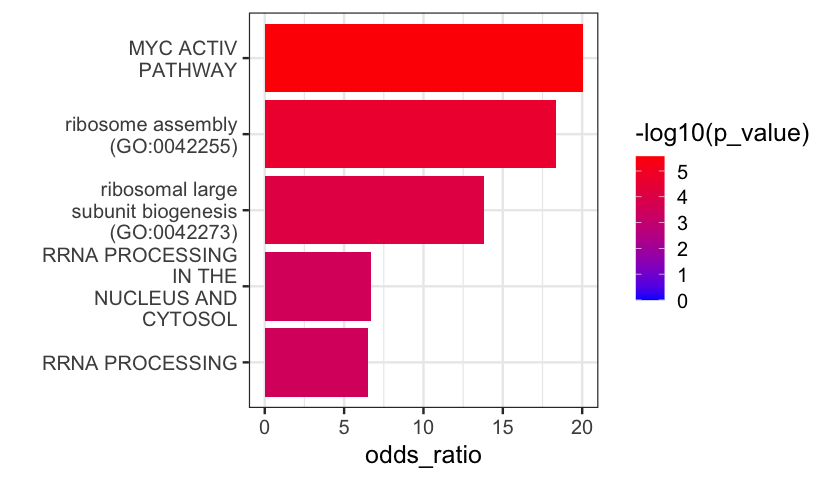

In [242]:
options(repr.plot.width=7, repr.plot.height=4)
hyper_res <- cdsrgsea::run_hyper(dict[,3]  %>% enframe(name = "gene",value = "z"),bind_rows(gene_sets$GO_Biological_Process,gene_sets$Canonical),gene_var = "gene",
                                 rank_var = "z",n_genes = 30)
p <- hyper_res  %>%  filter(size > 10)  %>% cdsrplots::make_gsea_bar(dir = "neg",n_shown = 5,remove_collection_name = T) + theme_bw(base_size = 15)
ggsave("./output/analysis/p3_gsea.svg",p,width = 7, height = 4, units = "in",dpi = 300)
p

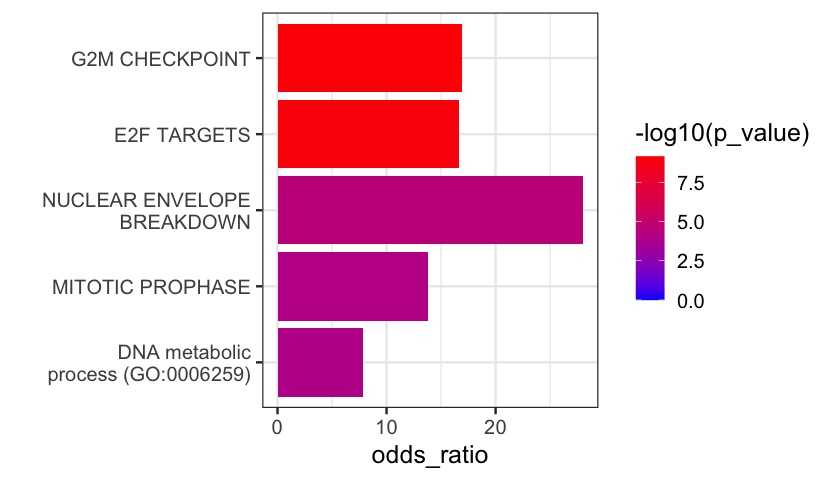

In [241]:
options(repr.plot.width=7, repr.plot.height=4)
hyper_res <- cdsrgsea::run_hyper(dict[,10]  %>% enframe(name = "gene",value = "z"),bind_rows(gene_sets$Hallmark,gene_sets$GO_Biological_Process,gene_sets$Canonical),gene_var = "gene",
                                 rank_var = "z",n_genes = 30)
p  <- hyper_res  %>%  filter(size > 10)  %>% cdsrplots::make_gsea_bar(dir = "neg",n_shown = 5,remove_collection_name = T) + theme_bw(base_size = 15)
ggsave("./output/analysis/p10_gsea.svg",p,width = 7, height = 4, units = "in",dpi = 300)
p

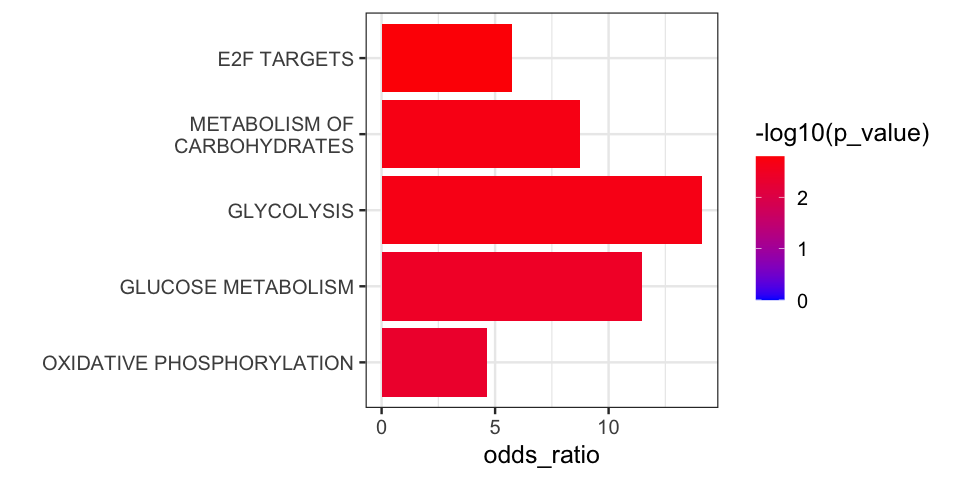

In [240]:
options(repr.plot.width=8, repr.plot.height=4)
hyper_res <- cdsrgsea::run_hyper(dict[,33]  %>% enframe(name = "gene",value = "z"),bind_rows(gene_sets$Hallmark,gene_sets$Canonical),gene_var = "gene",
                                 rank_var = "z",n_genes = 30)
p  <-  hyper_res  %>%  filter(size > 10)  %>% cdsrplots::make_gsea_bar(dir = "neg",n_shown = 5,remove_collection_name = T) + theme_bw(base_size = 15)
ggsave("./output/analysis/p33_gsea.svg",p,width = 8, height = 4, units = "in",dpi = 300)
p

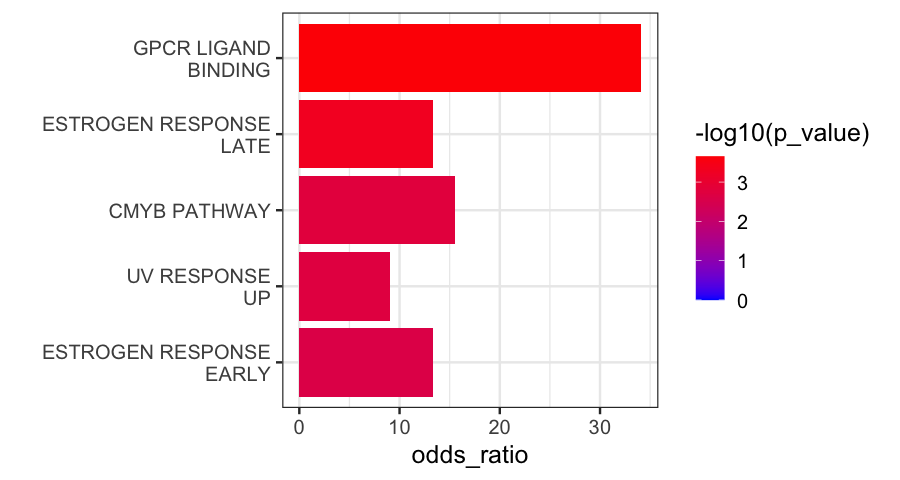

In [239]:
options(repr.plot.width=7.5, repr.plot.height=4)
hyper_res <- cdsrgsea::run_hyper(dict[,40]  %>% enframe(name = "gene",value = "z"),bind_rows(gene_sets$Hallmark,gene_sets$Canonical),gene_var = "gene",
                                 rank_var = "z",n_genes = 30)
p  <-  hyper_res  %>%  filter(size > 10)  %>% cdsrplots::make_gsea_bar(dir = "neg",n_shown = 5,remove_collection_name = T) + theme_bw(base_size = 15)
ggsave("./output/analysis/p40_gsea.svg",p,width = 7.5, height = 4, units = "in",dpi = 300)
p

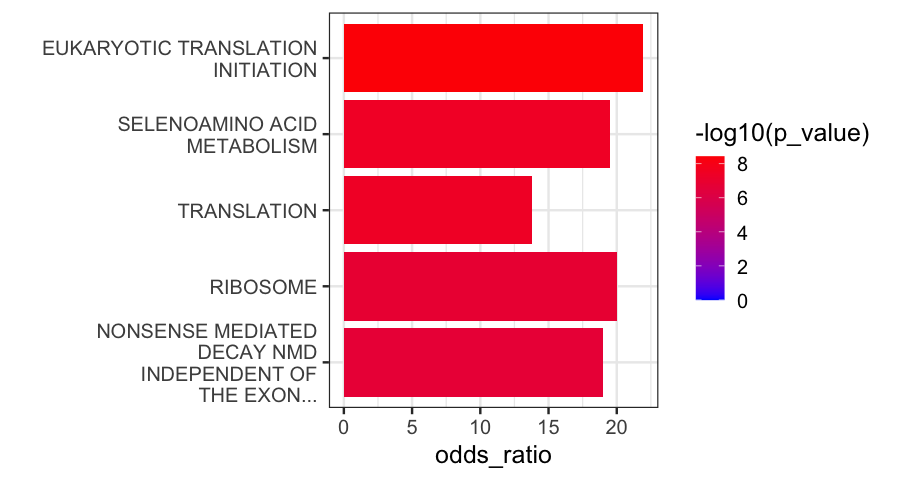

In [238]:
options(repr.plot.width=7.5, repr.plot.height=4)
hyper_res <- cdsrgsea::run_hyper(dict[,79]  %>% enframe(name = "gene",value = "z"),bind_rows(gene_sets$Hallmark,gene_sets$Canonical),gene_var = "gene",
                                 rank_var = "z",n_genes = 30)
p  <-  hyper_res  %>%  filter(size > 10)  %>% cdsrplots::make_gsea_bar(dir = "neg",n_shown = 5,remove_collection_name = T) + theme_bw(base_size = 15)
ggsave("./output/analysis/p79_gsea.svg",p,width = 7.5, height = 4, units = "in",dpi = 300)
p